# Totato disease classfication

Dataset Link :https://www.kaggle.com/datasets/emmarex/plantdisease

### Mounting drive for data loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/TD/TD.zip'

### Loading the dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models,layers
# from tensorflow import keras
# from tensorflow.keras import layers
print("D o n e B r o")

D o n e B r o


In [ ]:
# from tensorflow import keras
# from tensorflow.keras import layers

### Making constants

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Loading the image file in colab with tf.keras

In [8]:
data =tf.keras.preprocessing.image_dataset_from_directory(
    r'/content/TD/Untitled Folder',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = (BATCH_SIZE))

Found 4500 files belonging to 3 classes.


In [9]:
class_names = data.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [10]:
len(data)

141

In [13]:
141*32

4512

In [14]:
for image_batch, labels_batch in data.take(1):
    print('batch_size,dimensions,channels:',image_batch.shape)
    print(labels_batch.numpy())

batch_size,dimensions,channels: (32, 256, 256, 3)
[1 2 2 1 0 1 0 0 1 1 1 1 0 2 2 1 1 0 1 1 1 2 0 0 1 1 2 2 1 0 1 0]


In [15]:
for image_batch, labels_batch in data.take(1):
    print(image_batch[0].numpy())


[[[221. 222. 240.]
  [214. 215. 233.]
  [208. 209. 227.]
  ...
  [122. 122. 146.]
  [127. 127. 151.]
  [128. 128. 152.]]

 [[211. 212. 230.]
  [208. 209. 227.]
  [206. 207. 225.]
  ...
  [147. 147. 171.]
  [159. 159. 183.]
  [150. 150. 174.]]

 [[203. 204. 222.]
  [204. 205. 223.]
  [207. 208. 226.]
  ...
  [135. 135. 159.]
  [146. 146. 170.]
  [140. 140. 164.]]

 ...

 [[163. 167. 192.]
  [165. 169. 194.]
  [169. 173. 198.]
  ...
  [ 14.  14.  14.]
  [ 14.  14.  14.]
  [ 15.  15.  15.]]

 [[162. 166. 191.]
  [166. 170. 195.]
  [170. 174. 199.]
  ...
  [ 14.  14.  12.]
  [ 14.  14.  14.]
  [ 15.  15.  15.]]

 [[163. 167. 192.]
  [167. 171. 196.]
  [171. 175. 200.]
  ...
  [ 14.  14.  12.]
  [ 14.  14.  14.]
  [ 15.  15.  15.]]]


<Figure size 576x576 with 0 Axes>

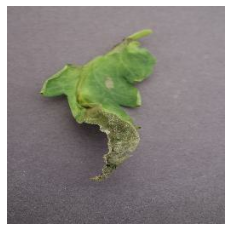

<Figure size 576x576 with 0 Axes>

In [16]:
plt.imshow(image_batch[3].numpy().astype("uint8"))
plt.axis("off")
plt.figure(figsize=(8,8))

### Visualizing the classes

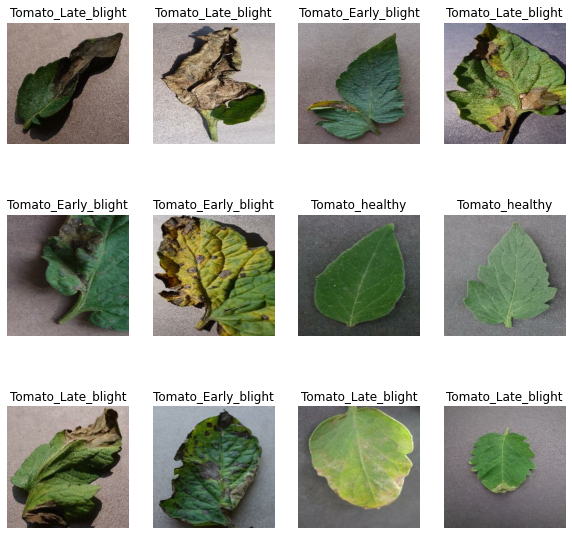

In [17]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in data.take(1):
    for i in range(12):
      ax = plt.subplot(3,4,i+1)
      plt.imshow(image_batch[i].numpy().astype("uint8"))
      plt.title(class_names[labels_batch[i]])
      plt.axis("off")
    

### Train_Test_Split

In [18]:
len(data)

141

In [19]:
train_size = 0.8
len(data)*train_size

112.80000000000001

In [28]:
train_ds = data.take(112)
len(train_ds)

112

In [29]:
test_ds = data.skip(112)
len(test_ds)

29

In [30]:
val_size = 0.1
len(data)*val_size

14.100000000000001

In [23]:
#val_ds = test_ds.take(7)
#len(val_ds)

In [31]:
val_ds = test_ds.take(14)
len(val_ds)

14

In [33]:
# test_ds = test_ds.skip(14)
# len(test_ds)

0

### Partitioning the data

In [34]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):

  ds_size = len(ds)
  
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)
  
  train_size = int(train_split*ds_size)
  val_size = int(val_split*ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  
  return train_ds,val_ds,test_ds

In [35]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(data)

In [36]:
len(train_ds)

112

In [37]:
len(val_ds)

14

In [38]:
len(test_ds)

15

Cache, Shuffle, and Prefetch the Dataset

In [39]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
print('done')

done


## Model Building 

In [40]:
resize_and_rescale=tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),

])

In [41]:
data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),

])

In [62]:
# Defining the model
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.Dropout(0.3),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.Dropout(0.3),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.Dropout(0.3),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.3),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.3),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.3),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation = 'softmax'),
])
model.build(input_shape=input_shape)
print('done')

done


In [63]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 dropout (Dropout)           (32, 254, 254, 32)        0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (32, 127, 127, 32)        0         
                                                      

In [64]:
from tensorflow.python.data.ops.options import OptimizationOptions
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False),
    metrics =['accuracy'])
print('done')

done


In [47]:
# early_stopping = keras.callbacks.EarlyStopping(
#     patience=10,
#     min_delta=0.001,
#     restore_best_weights=True,
# )

In [65]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    # callbacks=[early_stopping]
)

Epoch 1/50
112/112 [==============================] - 16s 129ms/step - loss: 1.0724 - accuracy: 0.4348 - val_loss: 1.0899 - val_accuracy: 0.5871
Epoch 2/50
112/112 [==============================] - 14s 127ms/step - loss: 0.7261 - accuracy: 0.6842 - val_loss: 0.9845 - val_accuracy: 0.7433
Epoch 3/50
112/112 [==============================] - 14s 129ms/step - loss: 0.4658 - accuracy: 0.7707 - val_loss: 0.9117 - val_accuracy: 0.6094
Epoch 4/50
112/112 [==============================] - 14s 127ms/step - loss: 0.4306 - accuracy: 0.7917 - val_loss: 0.8374 - val_accuracy: 0.5000
Epoch 5/50
112/112 [==============================] - 14s 127ms/step - loss: 0.3960 - accuracy: 0.8429 - val_loss: 0.8253 - val_accuracy: 0.6317
Epoch 6/50
112/112 [==============================] - 14s 126ms/step - loss: 0.3653 - accuracy: 0.8536 - val_loss: 0.9182 - val_accuracy: 0.5000
Epoch 7/50
112/112 [==============================] - 14s 126ms/step - loss: 0.3444 - accuracy: 0.8600 - val_loss: 0.8703 - val_ac

In [66]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 1s 33ms/step - loss: 0.8505 - accuracy: 0.6583


In [67]:
history

In [68]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 112}

In [69]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [70]:
len(history.history['loss'])

50

In [71]:
type(history.history['loss'])

list

In [72]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.0724034309387207,
 0.7260914444923401,
 0.4658394455909729,
 0.4305569529533386,
 0.39595693349838257]

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

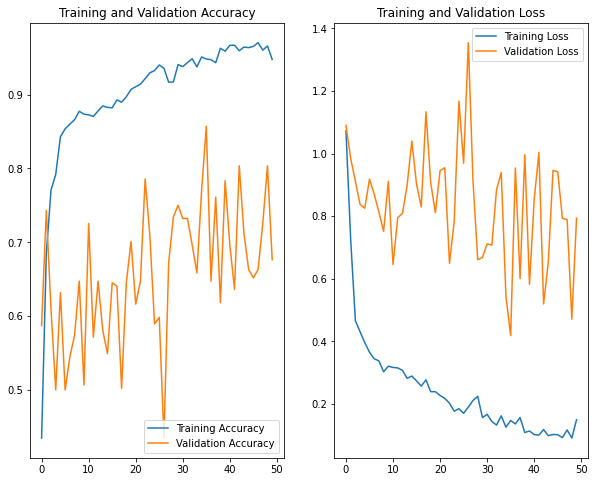

In [76]:
plt.figure(figsize=(10,8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Run prediction on a sample image

first image to predict
actual label: Tomato_Early_blight
1/1 [==============================] - 0s 29ms/step
predicted label: Tomato_Late_blight


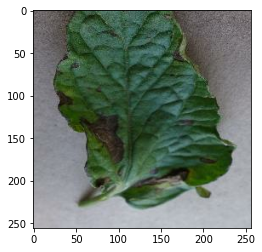

In [80]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Write a function for inference

In [81]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample images

1/1 [==============================] - 0s 23ms/step


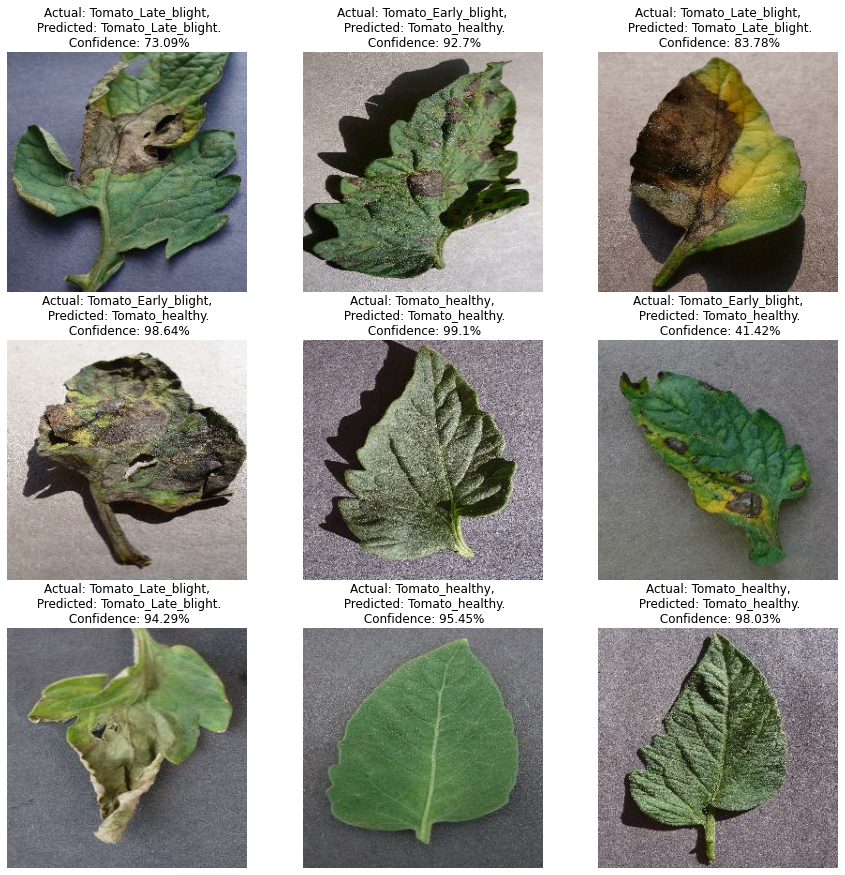

In [82]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
# model_version = 1
# model.save(f"../models/{model_version}")

In [ ]:
import os
model_version =([int (i) for i in os.listdir("../models/")])
model.save(f"../models/{model_version}")